In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pystan
import re
from sklearn.utils import shuffle
from sklearn import preprocessing
import pymc

%matplotlib inline  
plt.style.use('ggplot')

# Regression for Moore's Law
## Ridge Regression

In [2]:
# Load and preprocess data
X = []
Y = []

non_decimal = re.compile(r'[^\d]+')

for line in open('moore.csv'):
    r = line.split('\t')
    x = int(non_decimal.sub('', r[2].split('[')[0]))
    y = int(non_decimal.sub('', r[1].split('[')[0]))
    X.append(x)
    Y.append(y)

X = np.array(X)
Y = np.array(Y)
X.shape = (X.shape[0], 1)
Y = np.log(Y)

def preprocess_data(X, Y):    
    # split data into training and test set
    X, Y = shuffle(X, Y)
    N, M = X.shape
    idx = int(0.8*N)
    X_train = X[:idx, :]
    Y_train = Y[:idx]
    N_train = idx
    X_test = X[idx:, :]
    Y_test = Y[idx:]
    N_test = N - N_train

    # Normalize data
    train_mean = X_train.mean(axis=0)
    train_std = X_train.std(axis=0) 
    X_train = (X_train - train_mean) / train_std
    X_test = (X_test - train_mean) / train_std
    
    return X_train, Y_train, N_train, X_test, Y_test, N_test, M

(X_train, Y_train, N_train, X_test, Y_test, N_test, M) = preprocess_data(X, Y)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_36030b2f791b9c5af7b249ce0b9313d1 NOW.


Inference for Stan model: anon_model_36030b2f791b9c5af7b249ce0b9313d1.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

                  mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
intercept        16.67  3.9e-3   0.21  16.25  16.53  16.67   16.8  17.07   2923    1.0
beta[0]           4.82  4.6e-3   0.25   4.34   4.65   4.82   4.98   5.32   2907    1.0
sigma             0.86  2.8e-3   0.15   0.63   0.75   0.84   0.94   1.21   2913    1.0
lambda           11.52    0.64  37.47   2.46   4.87   7.46  12.34  39.27   3389    1.0
Y_pred[0]        18.93    0.01   0.89  17.19  18.35  18.93  19.53  20.65   3751    1.0
Y_pred[1]        20.33    0.01   0.89  18.53  19.76  20.33   20.9  22.16   3763    1.0
Y_pred[2]        22.83    0.02   0.92   21.0  22.23  22.84  23.42  24.63   3696    1.0
Y_pred[3]        19.98    0.01   0.88  18.16  19.43   20.0  20.56  21.75   4000    1.0
Y_pred[4]        22.48    0.

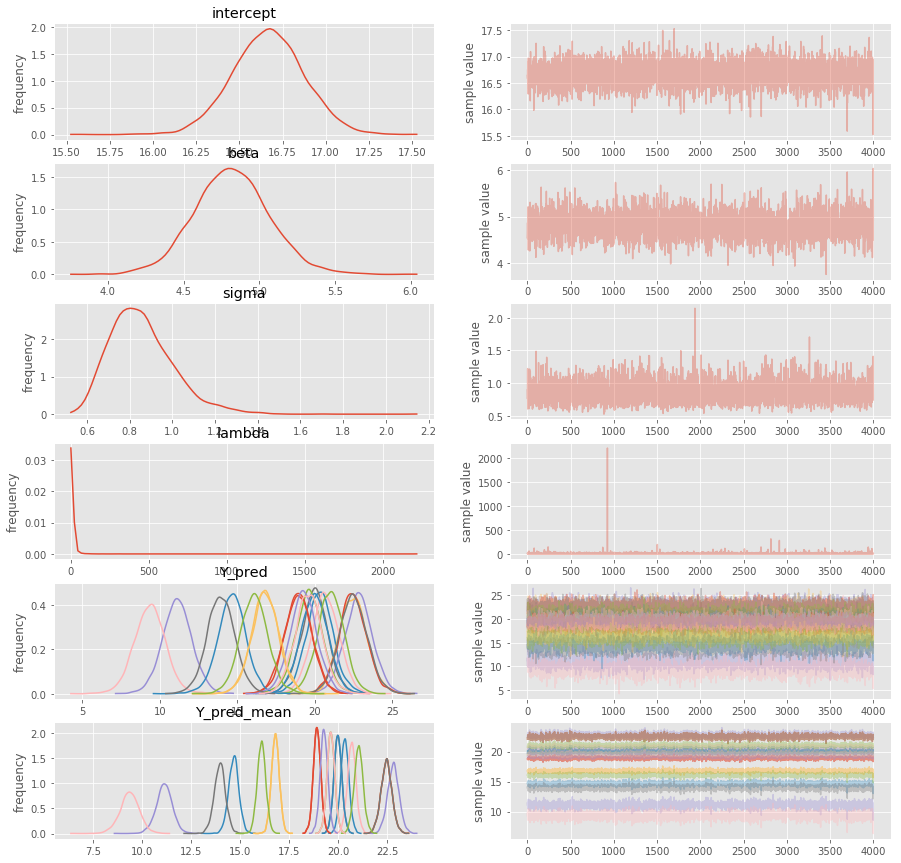

In [3]:
# Pystan model for Ridge Regression

ridge_code = """

data {
    int<lower=0> M; // number of predictors
    int<lower=0> N_train; // number of observations on training
    matrix[N_train, M] X_train; // predictors matrix for training
    vector[N_train] Y_train; // response vector for training
    int<lower=0> N_test; // number of observations on test
    matrix[N_test, M] X_test; // predictors matrix for test
}


parameters {
    real intercept;
    vector[M] beta;
    real<lower=0> sigma;
    real<lower=0> lambda;
}

model {
    vector[N_train] Y_mean;

    // Linear model
    Y_mean = X_train*beta + intercept;
    
    // Likelihood
    Y_train ~ normal(Y_mean, sigma);    
    
    // Priors
    intercept ~ normal(0, 10);
    beta ~ normal(0, lambda);
    sigma ~ cauchy(0, 10);
    lambda ~ cauchy(0, 10);
}

generated quantities {
    vector[N_test] Y_pred;
    vector[N_test] Y_pred_mean;
    
    Y_pred_mean = X_test*beta + intercept;
    for (i in 1:N_test)
        Y_pred[i] = normal_rng(Y_pred_mean[i], sigma); //the y values predicted by the model
}
"""

# dictionary containing data
data = {
    'X_train': X_test,
    'Y_train': Y_test,
    'N_train': N_test,
    'X_test': X_test,
    'N_test': N_test,
    'M': M
}

# fit model
ridge_fit = pystan.stan(model_code=ridge_code, data=data, iter=2000, chains=4)
print(ridge_fit)

fig = ridge_fit.plot()
fig.set_size_inches(15, 15)
Y_pred = ridge_fit.extract('Y_pred')['Y_pred']

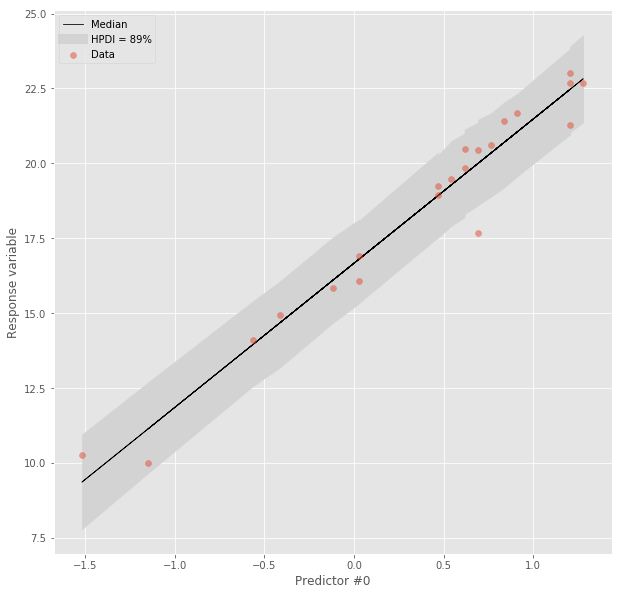

In [4]:
def prediction_plot(fit, pred_number=0):
    Y_hpdi = pymc.utils.hpd(Y_pred, 0.11)
    Y_lower = Y_hpdi[0, :]
    Y_upper = Y_hpdi[1, :]
    
    intercept = np.median(fit.extract('intercept')['intercept'])
    beta = np.median(fit.extract('beta')['beta'], axis=0)
    
    fig, ax = plt.subplots(1)
    fig.set_size_inches(10, 10)
    X_test_lin = X_test[:, pred_number]
    if not np.isscalar(beta):
        beta = beta[pred_number]
        
    Y_median = X_test_lin * beta + intercept
    
    ax.plot(X_test_lin, Y_median, linewidth=0.8, color='k', label='Median', zorder=2)
    ax.scatter(X_test_lin, Y_test, alpha=0.5, label='Data', zorder=3)
    sorted_x = X_test_lin.argsort()
    Y_upper = Y_upper[sorted_x]
    Y_lower = Y_lower[sorted_x]
    X_test_sorted = X_test_lin[sorted_x]
    ax.fill_between(X_test_sorted, Y_upper, Y_lower, color='lightgrey')
    ax.plot([], [], color='lightgrey', label='HPDI = 89%', linewidth=10)
    ax.legend(loc='upper left')
    plt.xlabel('Predictor #%d' % (pred_number))
    plt.ylabel('Response variable')    
    
prediction_plot(ridge_fit)

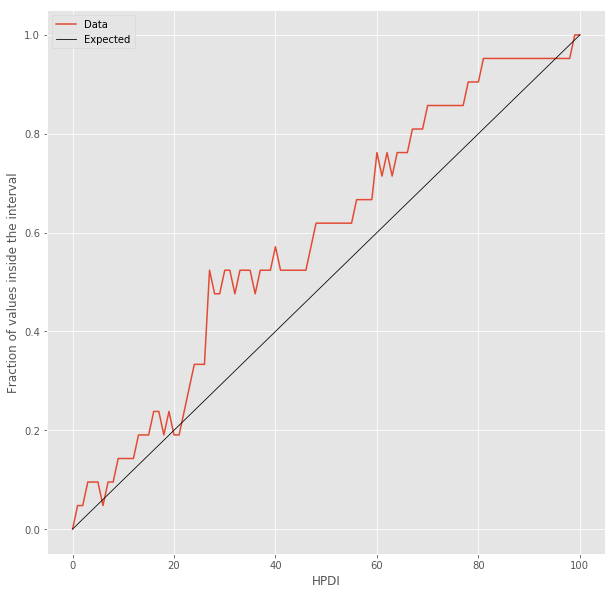

In [5]:
# Calibration curve
def calibration_curve(Y_pred, Y):
    calibration = np.zeros(101)
    for i in range(101):
        Y_hpdi = pymc.utils.hpd(Y_pred, max((100.0 - i) / 100.0, 1e-10))
        calibration[i] = ((Y >= Y_hpdi[0, :]) & (Y <= Y_hpdi[1, :])).mean()
    plt.figure(figsize=(10, 10))
    plt.plot(calibration, label='Data')
    line = np.linspace(0, 100, 100)
    plt.plot(line, line / 100.0, color='k', linewidth=0.8, label='Expected')
    plt.xlabel('HPDI')
    plt.ylabel('Fraction of values inside the interval')
    plt.legend(loc='upper left')
    
calibration_curve(Y_pred, Y_test)

def RMSE(Y_pred, Y_test):
    diff = (Y_pred - Y_test).flatten()
    return np.sqrt((diff.dot(diff)).mean())

In [6]:
print('RMSE = %.4e' %(RMSE(Y_pred, Y_test)))

RMSE = 3.4265e+02


## Lasso Regresion

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_bf816625dbf7aab00ae5c2b50df84878 NOW.


Inference for Stan model: anon_model_bf816625dbf7aab00ae5c2b50df84878.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

                  mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
intercept        16.67  4.2e-3   0.21  16.24  16.53  16.68  16.82   17.1   2525    1.0
beta[0]           4.81  5.0e-3   0.26    4.3   4.64   4.81   4.99    5.3   2627    1.0
sigma             0.86  3.3e-3   0.15   0.61   0.75   0.84   0.95    1.2   2207    1.0
lambda           12.87    0.65  28.26   1.78   4.45   7.73  13.92  51.04   1916    1.0
Y_pred[0]        18.93    0.01   0.88   17.2  18.35  18.93   19.5  20.69   3675    1.0
Y_pred[1]        20.35    0.01   0.88  18.56   19.8  20.35  20.92  22.08   4000    1.0
Y_pred[2]        22.81    0.01   0.93  20.98  22.22  22.81  23.39  24.69   4000    1.0
Y_pred[3]         20.0    0.01    0.9  18.21  19.42   20.0  20.57  21.79   4000    1.0
Y_pred[4]        22.47    0.

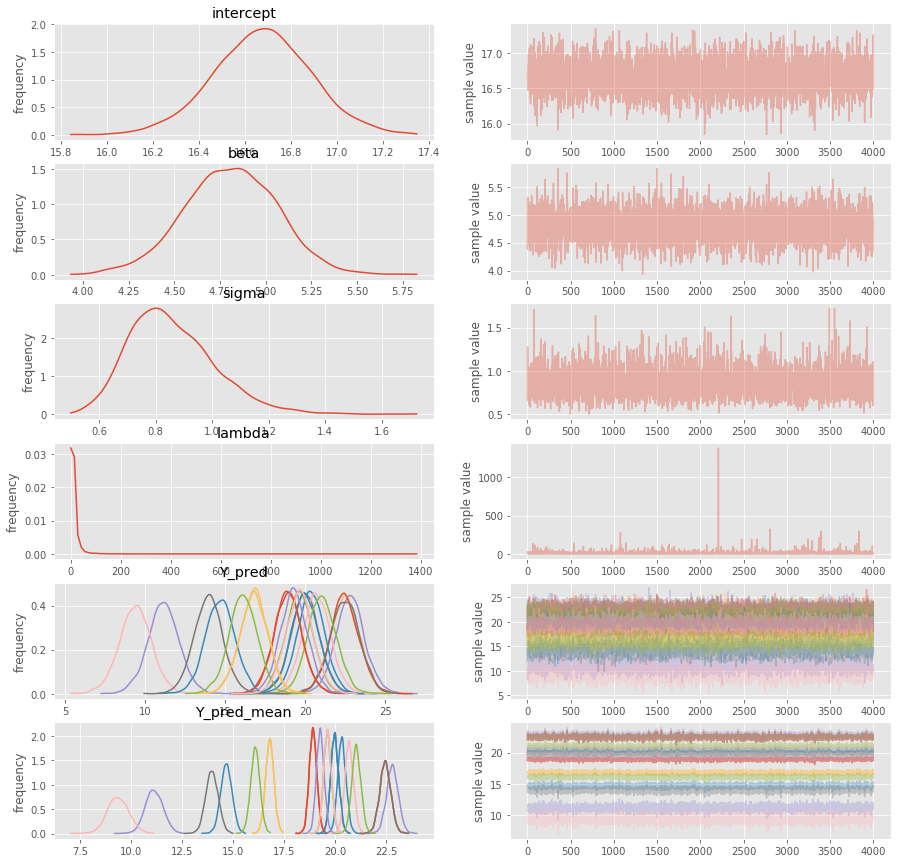

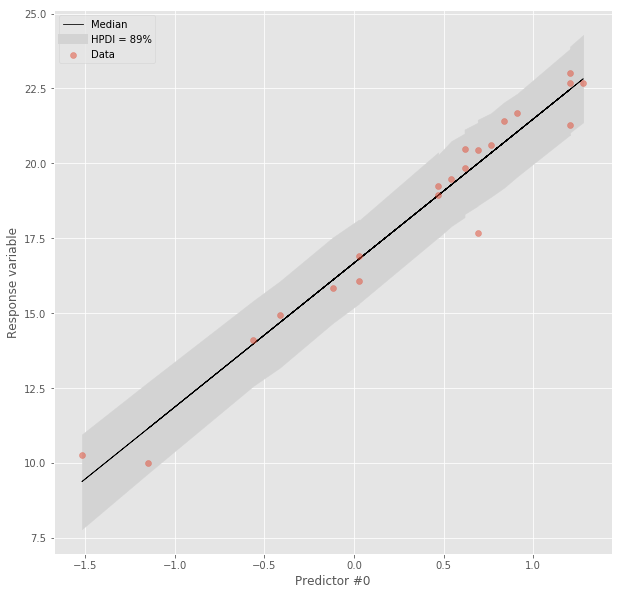

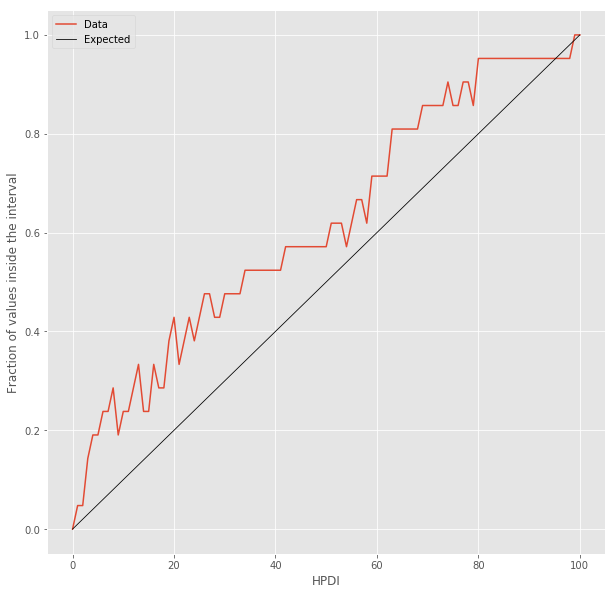

In [7]:
lasso_code = """

data {
    int<lower=0> M; // number of predictors
    int<lower=0> N_train; // number of observations on training
    matrix[N_train, M] X_train; // predictors matrix for training
    vector[N_train] Y_train; // response vector for training
    int<lower=0> N_test; // number of observations on test
    matrix[N_test, M] X_test; // predictors matrix for test
}


parameters {
    real intercept;
    vector[M] beta;
    real<lower=0> sigma;
    real<lower=0> lambda;
}

model {
    vector[N_train] Y_mean;

    // Linear model
    Y_mean = X_train*beta + intercept;
    
    // Likelihood
    Y_train ~ normal(Y_mean, sigma);    
    
    // Priors
    intercept ~ normal(0, 10);
    beta ~ double_exponential(0, lambda);
    sigma ~ cauchy(0, 10);
    lambda ~ cauchy(0, 10);
}

generated quantities {
    vector[N_test] Y_pred;
    vector[N_test] Y_pred_mean;
    
    Y_pred_mean = X_test*beta + intercept;
    for (i in 1:N_test)
        Y_pred[i] = normal_rng(Y_pred_mean[i], sigma); //the y values predicted by the model
}
"""

# fit model
lasso_fit = pystan.stan(model_code=lasso_code, data=data, iter=2000, chains=4)
print(lasso_fit)

fig = lasso_fit.plot()
fig.set_size_inches(15, 15)
prediction_plot(lasso_fit)
Y_pred = lasso_fit.extract('Y_pred')['Y_pred']
calibration_curve(Y_pred, Y_test)

In [8]:
print('RMSE = %.4e' %(RMSE(Y_pred, Y_test)))

RMSE = 3.4321e+02


## Robust Regression

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_a1886ccc94022ca5d08f79196d33213a NOW.


Inference for Stan model: anon_model_a1886ccc94022ca5d08f79196d33213a.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

                  mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
intercept         16.8  3.6e-3   0.16  16.46  16.71  16.82   16.9  17.09   1868    1.0
beta[0]           4.94  5.4e-3   0.23   4.51   4.79   4.92   5.08   5.44   1809    1.0
sigma             0.59  2.8e-3   0.14   0.36   0.49   0.57   0.67   0.91   2446    1.0
Y_pred[0]        19.12    0.01   0.62  17.83  18.73  19.12  19.52  20.32   3719    1.0
Y_pred[1]        20.58 10.0e-3   0.63  19.38  20.19  20.57  20.95   21.9   4000    1.0
Y_pred[2]        23.13    0.01   0.64  21.82  22.72  23.14  23.53  24.39   3842    1.0
Y_pred[3]        20.21  9.7e-3   0.61  18.93  19.83  20.22  20.59  21.43   4000    1.0
Y_pred[4]        22.75    0.01   0.63   21.5  22.35  22.77  23.15  24.03   3944    1.0
Y_pred[5]        19.86  9.7e

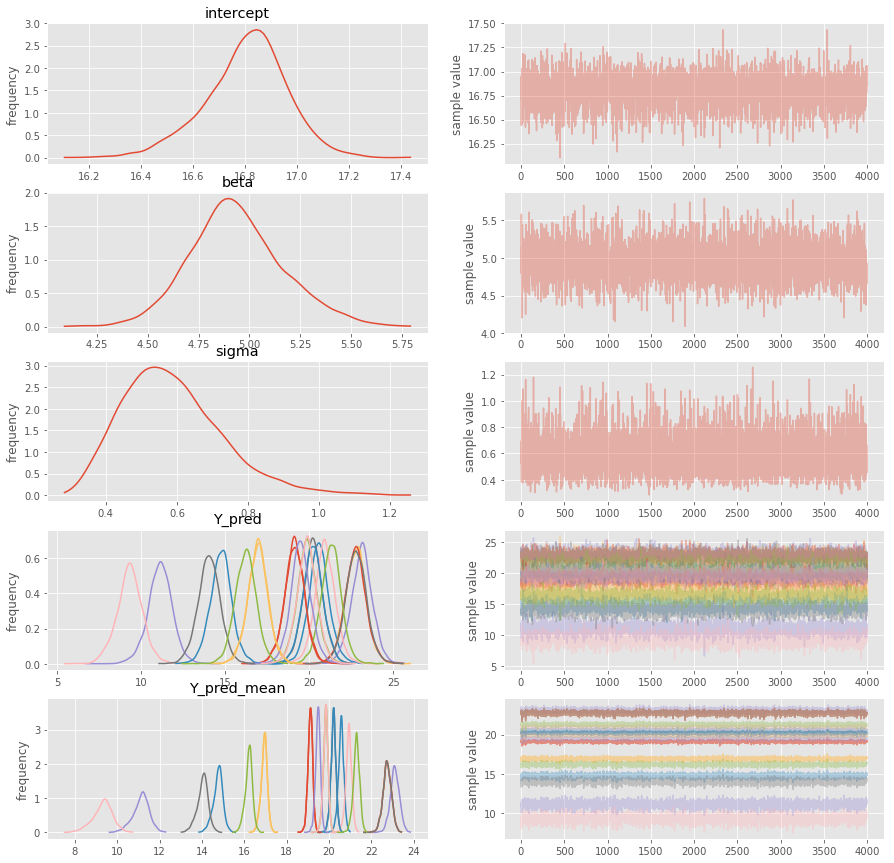

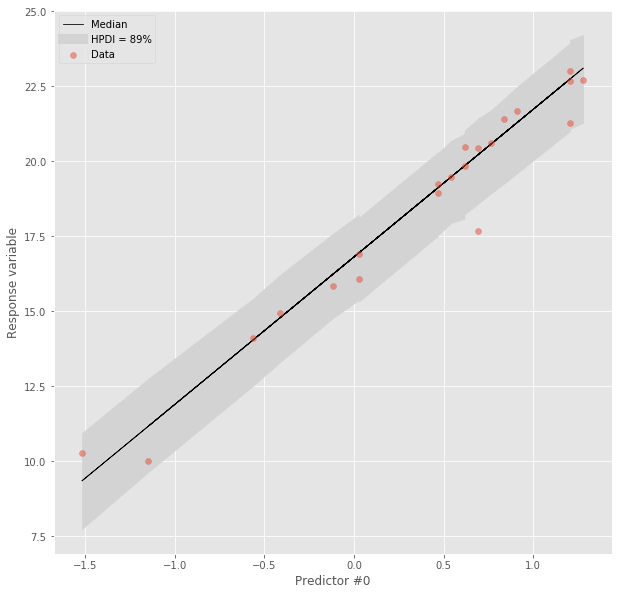

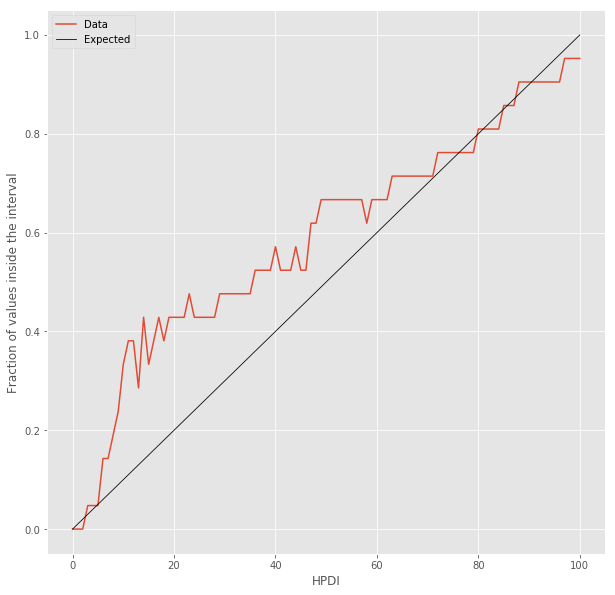

In [9]:
robust_code = """

data {
    int<lower=0> M; // number of predictors
    int<lower=0> N_train; // number of observations on training
    matrix[N_train, M] X_train; // predictors matrix for training
    vector[N_train] Y_train; // response vector for training
    int<lower=0> N_test; // number of observations on test
    matrix[N_test, M] X_test; // predictors matrix for test
}


parameters {
    real intercept;
    vector[M] beta;
    real<lower=0> sigma;
    //real<lower=0> lambda;
}

model {
    vector[N_train] Y_mean;

    // Linear model
    Y_mean = X_train*beta + intercept;
    
    // Likelihood
    Y_train ~ double_exponential(Y_mean, sigma);    
    
    // Priors
    intercept ~ normal(0, 10);
    beta ~ cauchy(0, 10);
    sigma ~ cauchy(0, 10);
}

generated quantities {
    vector[N_test] Y_pred;
    vector[N_test] Y_pred_mean;
    
    Y_pred_mean = X_test*beta + intercept;
    for (i in 1:N_test)
        Y_pred[i] = normal_rng(Y_pred_mean[i], sigma); //the y values predicted by the model
}
"""

# fit model
robust_fit = pystan.stan(model_code=robust_code, data=data, iter=2000, chains=4)
print(robust_fit)

fig = robust_fit.plot()
fig.set_size_inches(15, 15)
prediction_plot(robust_fit)
Y_pred = robust_fit.extract('Y_pred')['Y_pred']
calibration_curve(Y_pred, Y_test)

In [10]:
print('RMSE = %.4e' %(RMSE(Y_pred, Y_test)))

RMSE = 2.9359e+02


## MAP Estimate

In [11]:
map_code = """

data {
    int<lower=0> M; // number of predictors
    int<lower=0> N_train; // number of observations on training
    matrix[N_train, M] X_train; // predictors matrix for training
    vector[N_train] Y_train; // response vector for training
    int<lower=0> N_test; // number of observations on test
    matrix[N_test, M] X_test; // predictors matrix for test
}


parameters {
    real intercept;
    vector[M] beta;
    real<lower=0> sigma;
}

model {
    vector[N_train] Y_mean;

    // Linear model
    Y_mean = X_train*beta + intercept;
    
    // Likelihood
    Y_train ~ normal(Y_mean, sigma);    
    
    // Priors
    intercept ~ normal(0, 10);
    beta ~ cauchy(0, 20);
    sigma ~ cauchy(0, 10);
}

generated quantities {
    vector[N_test] Y_pred;
    vector[N_test] Y_pred_mean;
    
    Y_pred_mean = X_test*beta + intercept;
    for (i in 1:N_test)
        Y_pred[i] = normal_rng(Y_pred_mean[i], sigma); //the y values predicted by the model
}
"""

map_fit = pystan.StanModel(model_code=map_code)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_b0869c5092bd14e3015751434dedda93 NOW.


RMSE = 1.0840e+02


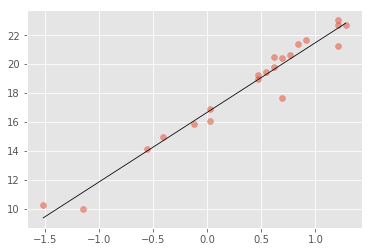

In [22]:
map_params = map_fit.optimizing(data=data)

intercept = map_params['intercept']
beta = map_params['beta']
Y_pred = X_test * beta + intercept

plt.scatter(X_test, Y_test, alpha=0.5)
sorted_x = X_test[:, 0].argsort()
X_test_sorted = X_test[sorted_x, 0]
Y_test_sorted = Y_pred[sorted_x]
plt.plot(X_test_sorted, Y_test_sorted, color='k', linewidth=0.8)
plt.xlabel('Predictor #%d' % (pred_number))
plt.ylabel('Response variable') 

print('RMSE = %.4e' %(RMSE(Y_pred, Y_test)))